In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpf53k39vj/pubring.gpg' created
gpg: /tmp/tmpf53k39vj/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [1]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
!pip install -q keras

In [0]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [0]:
def load_data(data_path: str, test_size=0.2, random_state=42, info=False):
    """Load data from file.
    
    Args:
        data_path: str, file path to read data
        test_size: float, the ratio of test / all
        random_state: int, random seed to split data
        info: bool, control info print
    Returns:
        train_data: np.array, train set
        test_data: np.array, test set
    """
    # imgs = [np.array(Image.open(d)) for d in Path(data_path).iterdir()]
    imgs = []
    for d in Path(data_path).iterdir():
        if info:
            print('Load image: ' + d.name)
        imgs.append(np.array(Image.open(d)))
    data = np.array(imgs)
    train_data, test_data = train_test_split(
        data, test_size=test_size, random_state=random_state)
    return train_data, test_data

In [0]:
def load_label(label_path: str, test_size=0.2, random_state=42):
    """Load label from file.
    
    Args:
        label_path: str, file path to read label
        test_size: float, the ratio of test / all, 
            this arg should match up test_size in load_data
        random_state: int, random seed to split data
            this arg should match up random_state in load_data
    """
    with open(label_path, 'r') as f:
        labels = f.readline()
    train_label, test_label = train_test_split(
        labels.split('\t'), test_size=test_size, random_state=random_state)
    le = LabelEncoder()
    le.fit(train_label)
    return le.transform(train_label), le.transform(test_label)

In [0]:
train_label, test_label = load_label('./drive/data/FacePlace/Asian.txt')

In [0]:
train_data, test_data = load_data('./drive/data/FacePlace/Asian/')

In [0]:
train_data = train_data.astype('float32') / 255
test_data = test_data.astype('float32') / 255

In [7]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # randomly flip images
datagen.fit(train_data)

In [0]:
from keras import layers
from keras import models
from keras import optimizers

In [0]:
def vanilla_cnn(input_shape: tuple, classes: int):
    """Implement vanilla ConvNet model."""
    model = models.Sequential()
    model.add(
        layers.Conv2D(32, (3, 3), activation='relu',
                      padding='same',
                      input_shape=input_shape))
#     model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Dropout(0.5))
    
#     model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [0]:
model = vanilla_cnn(input_shape=train_data[0].shape, classes=train_label.max() + 1)

In [12]:
history = model.fit_generator(
    datagen.flow(train_data, train_label, batch_size=20),
    epochs=80, validation_data=(test_data, test_label))

Epoch 1/80
52/52 [==============================] - 47s 896ms/step - loss: 4.1068 - acc: 0.0221 - val_loss: 3.9388 - val_acc: 0.0233
Epoch 2/80
52/52 [==============================] - 32s 623ms/step - loss: 3.8352 - acc: 0.0587 - val_loss: 3.7348 - val_acc: 0.0506
Epoch 3/80
52/52 [==============================] - 32s 622ms/step - loss: 3.6343 - acc: 0.0596 - val_loss: 3.6909 - val_acc: 0.0739
Epoch 4/80
52/52 [==============================] - 32s 623ms/step - loss: 3.5444 - acc: 0.0806 - val_loss: 3.5191 - val_acc: 0.0856
Epoch 5/80
52/52 [==============================] - 32s 621ms/step - loss: 3.4000 - acc: 0.1034 - val_loss: 3.4011 - val_acc: 0.1284
Epoch 6/80
 7/52 [===>..........................] - ETA: 26s - loss: 3.2593 - acc: 0.1214

52/52 [==============================] - 32s 623ms/step - loss: 3.2896 - acc: 0.1125 - val_loss: 3.3572 - val_acc: 0.1051
Epoch 7/80
52/52 [==============================] - 32s 621ms/step - loss: 3.2079 - acc: 0.1449 - val_loss: 3.2480 - val_acc: 0.1323
Epoch 8/80
52/52 [==============================] - 32s 624ms/step - loss: 3.1375 - acc: 0.1620 - val_loss: 3.1668 - val_acc: 0.1868
Epoch 9/80
52/52 [==============================] - 32s 625ms/step - loss: 3.1202 - acc: 0.1539 - val_loss: 3.2146 - val_acc: 0.1362
Epoch 10/80
52/52 [==============================] - 32s 622ms/step - loss: 3.0263 - acc: 0.1835 - val_loss: 3.2161 - val_acc: 0.1790
Epoch 11/80
11/52 [=====>........................] - ETA: 24s - loss: 2.9900 - acc: 0.1727

52/52 [==============================] - 32s 624ms/step - loss: 3.0150 - acc: 0.1951 - val_loss: 3.1012 - val_acc: 0.1712
Epoch 12/80
52/52 [==============================] - 32s 623ms/step - loss: 2.9145 - acc: 0.1931 - val_loss: 3.0352 - val_acc: 0.2412
Epoch 13/80
52/52 [==============================] - 32s 623ms/step - loss: 2.8050 - acc: 0.2351 - val_loss: 3.0658 - val_acc: 0.2062
Epoch 14/80
52/52 [==============================] - 32s 622ms/step - loss: 2.7762 - acc: 0.2489 - val_loss: 2.9567 - val_acc: 0.2451
Epoch 15/80
52/52 [==============================] - 32s 622ms/step - loss: 2.6422 - acc: 0.2840 - val_loss: 2.8746 - val_acc: 0.3035
Epoch 16/80
11/52 [=====>........................] - ETA: 24s - loss: 2.4582 - acc: 0.3000

52/52 [==============================] - 32s 623ms/step - loss: 2.5709 - acc: 0.2661 - val_loss: 2.8555 - val_acc: 0.2957
Epoch 17/80
52/52 [==============================] - 32s 624ms/step - loss: 2.5069 - acc: 0.2884 - val_loss: 2.7958 - val_acc: 0.3035
Epoch 18/80
52/52 [==============================] - 32s 624ms/step - loss: 2.3744 - acc: 0.3425 - val_loss: 2.6910 - val_acc: 0.3424
Epoch 19/80
52/52 [==============================] - 32s 623ms/step - loss: 2.2729 - acc: 0.3582 - val_loss: 2.7628 - val_acc: 0.3424
Epoch 20/80
52/52 [==============================] - 32s 623ms/step - loss: 2.2252 - acc: 0.3755 - val_loss: 2.6364 - val_acc: 0.3346
Epoch 21/80
11/52 [=====>........................] - ETA: 24s - loss: 1.9925 - acc: 0.4182

52/52 [==============================] - 32s 623ms/step - loss: 2.0370 - acc: 0.4235 - val_loss: 2.5078 - val_acc: 0.4475
Epoch 22/80
52/52 [==============================] - 32s 622ms/step - loss: 1.9691 - acc: 0.4584 - val_loss: 2.7187 - val_acc: 0.3969
Epoch 23/80
52/52 [==============================] - 32s 623ms/step - loss: 1.8968 - acc: 0.4342 - val_loss: 2.6444 - val_acc: 0.4086
Epoch 24/80
52/52 [==============================] - 33s 626ms/step - loss: 1.8496 - acc: 0.4677 - val_loss: 2.4457 - val_acc: 0.3969
Epoch 25/80
52/52 [==============================] - 32s 624ms/step - loss: 1.7765 - acc: 0.4986 - val_loss: 2.6198 - val_acc: 0.3930
Epoch 26/80
11/52 [=====>........................] - ETA: 24s - loss: 1.7221 - acc: 0.5455

52/52 [==============================] - 32s 625ms/step - loss: 1.7504 - acc: 0.4883 - val_loss: 2.5680 - val_acc: 0.4008
Epoch 27/80
52/52 [==============================] - 32s 622ms/step - loss: 1.6061 - acc: 0.5506 - val_loss: 2.4886 - val_acc: 0.4358
Epoch 28/80
52/52 [==============================] - 32s 623ms/step - loss: 1.5970 - acc: 0.5475 - val_loss: 2.3414 - val_acc: 0.5019
Epoch 29/80
52/52 [==============================] - 32s 624ms/step - loss: 1.4923 - acc: 0.5751 - val_loss: 2.3198 - val_acc: 0.4786
Epoch 30/80
52/52 [==============================] - 32s 623ms/step - loss: 1.4600 - acc: 0.5729 - val_loss: 2.4372 - val_acc: 0.4747
Epoch 31/80
11/52 [=====>........................] - ETA: 24s - loss: 1.2619 - acc: 0.5818

52/52 [==============================] - 32s 622ms/step - loss: 1.4481 - acc: 0.5735 - val_loss: 2.4036 - val_acc: 0.5058
Epoch 32/80
52/52 [==============================] - 32s 623ms/step - loss: 1.3651 - acc: 0.6051 - val_loss: 2.3696 - val_acc: 0.4942
Epoch 33/80
52/52 [==============================] - 32s 623ms/step - loss: 1.3610 - acc: 0.5983 - val_loss: 2.6643 - val_acc: 0.4397
Epoch 34/80
52/52 [==============================] - 32s 623ms/step - loss: 1.3686 - acc: 0.5825 - val_loss: 2.6543 - val_acc: 0.4553
Epoch 35/80
52/52 [==============================] - 32s 622ms/step - loss: 1.2960 - acc: 0.6064 - val_loss: 2.3244 - val_acc: 0.5175
Epoch 36/80
11/52 [=====>........................] - ETA: 24s - loss: 1.0697 - acc: 0.6727

52/52 [==============================] - 32s 625ms/step - loss: 1.1923 - acc: 0.6312 - val_loss: 2.3812 - val_acc: 0.5019
Epoch 37/80
52/52 [==============================] - 32s 620ms/step - loss: 1.2280 - acc: 0.6453 - val_loss: 2.1871 - val_acc: 0.4825
Epoch 38/80
52/52 [==============================] - 32s 621ms/step - loss: 1.0957 - acc: 0.6580 - val_loss: 2.5615 - val_acc: 0.4475
Epoch 39/80
52/52 [==============================] - 32s 621ms/step - loss: 1.1517 - acc: 0.6600 - val_loss: 2.2900 - val_acc: 0.5214
Epoch 40/80
52/52 [==============================] - 32s 620ms/step - loss: 1.1118 - acc: 0.7020 - val_loss: 2.1947 - val_acc: 0.5525
Epoch 41/80
11/52 [=====>........................] - ETA: 24s - loss: 0.9950 - acc: 0.6682

52/52 [==============================] - 32s 624ms/step - loss: 1.0760 - acc: 0.6753 - val_loss: 2.2637 - val_acc: 0.5253
Epoch 42/80
52/52 [==============================] - 32s 621ms/step - loss: 1.1026 - acc: 0.6839 - val_loss: 2.2329 - val_acc: 0.5486
Epoch 43/80
52/52 [==============================] - 32s 620ms/step - loss: 1.0018 - acc: 0.6814 - val_loss: 2.3891 - val_acc: 0.5447
Epoch 44/80
52/52 [==============================] - 32s 625ms/step - loss: 0.9172 - acc: 0.7357 - val_loss: 2.3268 - val_acc: 0.5292
Epoch 45/80
52/52 [==============================] - 33s 625ms/step - loss: 0.9331 - acc: 0.7185 - val_loss: 2.3552 - val_acc: 0.5564
Epoch 46/80
11/52 [=====>........................] - ETA: 24s - loss: 0.7605 - acc: 0.7636

52/52 [==============================] - 32s 625ms/step - loss: 0.8933 - acc: 0.7309 - val_loss: 2.2108 - val_acc: 0.5720
Epoch 47/80
52/52 [==============================] - 32s 623ms/step - loss: 0.9281 - acc: 0.7051 - val_loss: 2.2082 - val_acc: 0.5759
Epoch 48/80
52/52 [==============================] - 32s 621ms/step - loss: 0.8518 - acc: 0.7072 - val_loss: 2.2403 - val_acc: 0.5914
Epoch 49/80
52/52 [==============================] - 32s 623ms/step - loss: 0.8126 - acc: 0.7511 - val_loss: 2.2849 - val_acc: 0.5564
Epoch 50/80
52/52 [==============================] - 33s 625ms/step - loss: 0.8196 - acc: 0.7399 - val_loss: 2.2031 - val_acc: 0.5603
Epoch 51/80
11/52 [=====>........................] - ETA: 24s - loss: 0.6763 - acc: 0.7636

52/52 [==============================] - 32s 623ms/step - loss: 0.8145 - acc: 0.7399 - val_loss: 2.3180 - val_acc: 0.5447
Epoch 52/80
52/52 [==============================] - 32s 624ms/step - loss: 0.8140 - acc: 0.7378 - val_loss: 2.3887 - val_acc: 0.5642
Epoch 53/80
52/52 [==============================] - 32s 623ms/step - loss: 0.7759 - acc: 0.7657 - val_loss: 2.3488 - val_acc: 0.5642
Epoch 54/80
52/52 [==============================] - 32s 624ms/step - loss: 0.7572 - acc: 0.7693 - val_loss: 2.2458 - val_acc: 0.5720
Epoch 55/80
52/52 [==============================] - 32s 623ms/step - loss: 0.7686 - acc: 0.7551 - val_loss: 2.5043 - val_acc: 0.5097
Epoch 56/80
11/52 [=====>........................] - ETA: 24s - loss: 0.6588 - acc: 0.8091

52/52 [==============================] - 32s 625ms/step - loss: 0.7142 - acc: 0.7971 - val_loss: 2.4619 - val_acc: 0.5447
Epoch 57/80
52/52 [==============================] - 32s 622ms/step - loss: 0.7515 - acc: 0.7655 - val_loss: 2.2447 - val_acc: 0.5837
Epoch 58/80
52/52 [==============================] - 32s 622ms/step - loss: 0.6951 - acc: 0.7782 - val_loss: 2.3063 - val_acc: 0.5720
Epoch 59/80
52/52 [==============================] - 32s 624ms/step - loss: 0.7563 - acc: 0.7637 - val_loss: 2.3537 - val_acc: 0.5720
Epoch 60/80
52/52 [==============================] - 33s 626ms/step - loss: 0.6478 - acc: 0.8024 - val_loss: 2.2486 - val_acc: 0.5992
Epoch 61/80
11/52 [=====>........................] - ETA: 24s - loss: 0.4723 - acc: 0.8545

52/52 [==============================] - 33s 626ms/step - loss: 0.6052 - acc: 0.8041 - val_loss: 2.3752 - val_acc: 0.5914
Epoch 62/80
52/52 [==============================] - 32s 622ms/step - loss: 0.6724 - acc: 0.7984 - val_loss: 2.2671 - val_acc: 0.6070
Epoch 63/80
52/52 [==============================] - 32s 623ms/step - loss: 0.5777 - acc: 0.8242 - val_loss: 2.4078 - val_acc: 0.5798
Epoch 64/80
52/52 [==============================] - 32s 624ms/step - loss: 0.6021 - acc: 0.8197 - val_loss: 2.2909 - val_acc: 0.5875
Epoch 65/80
52/52 [==============================] - 32s 621ms/step - loss: 0.6244 - acc: 0.7955 - val_loss: 2.3754 - val_acc: 0.5914
Epoch 66/80
11/52 [=====>........................] - ETA: 24s - loss: 0.5260 - acc: 0.8091

52/52 [==============================] - 32s 622ms/step - loss: 0.6348 - acc: 0.8099 - val_loss: 2.2676 - val_acc: 0.6070
Epoch 67/80
52/52 [==============================] - 32s 619ms/step - loss: 0.5072 - acc: 0.8263 - val_loss: 2.2657 - val_acc: 0.6031
Epoch 68/80
52/52 [==============================] - 32s 625ms/step - loss: 0.5803 - acc: 0.8118 - val_loss: 2.2390 - val_acc: 0.5759
Epoch 69/80
52/52 [==============================] - 32s 624ms/step - loss: 0.5373 - acc: 0.8309 - val_loss: 2.3496 - val_acc: 0.5914
Epoch 70/80
52/52 [==============================] - 32s 621ms/step - loss: 0.5790 - acc: 0.8215 - val_loss: 2.3171 - val_acc: 0.6070
Epoch 71/80
11/52 [=====>........................] - ETA: 24s - loss: 0.5004 - acc: 0.8409

52/52 [==============================] - 32s 623ms/step - loss: 0.5138 - acc: 0.8463 - val_loss: 2.3110 - val_acc: 0.5875
Epoch 72/80
52/52 [==============================] - 32s 621ms/step - loss: 0.5340 - acc: 0.8307 - val_loss: 2.3811 - val_acc: 0.5992
Epoch 73/80
52/52 [==============================] - 34s 645ms/step - loss: 0.5106 - acc: 0.8271 - val_loss: 2.4344 - val_acc: 0.5875
Epoch 74/80
52/52 [==============================] - 32s 624ms/step - loss: 0.5518 - acc: 0.8253 - val_loss: 2.6040 - val_acc: 0.5603
Epoch 75/80
52/52 [==============================] - 32s 623ms/step - loss: 0.5767 - acc: 0.8221 - val_loss: 2.4855 - val_acc: 0.5875
Epoch 76/80
11/52 [=====>........................] - ETA: 24s - loss: 0.5025 - acc: 0.8500

52/52 [==============================] - 32s 622ms/step - loss: 0.5406 - acc: 0.8301 - val_loss: 2.4754 - val_acc: 0.5603
Epoch 77/80
52/52 [==============================] - 32s 624ms/step - loss: 0.5425 - acc: 0.8278 - val_loss: 2.5791 - val_acc: 0.5875
Epoch 78/80
52/52 [==============================] - 32s 622ms/step - loss: 0.5185 - acc: 0.8365 - val_loss: 2.3553 - val_acc: 0.6226
Epoch 79/80
52/52 [==============================] - 32s 624ms/step - loss: 0.5433 - acc: 0.8301 - val_loss: 2.5132 - val_acc: 0.5759
Epoch 80/80
52/52 [==============================] - 32s 623ms/step - loss: 0.5382 - acc: 0.8336 - val_loss: 2.5931 - val_acc: 0.5564


In [0]:
model.save('./drive/asian_vanilla2.h5')

In [0]:
import matplotlib.pyplot as plt

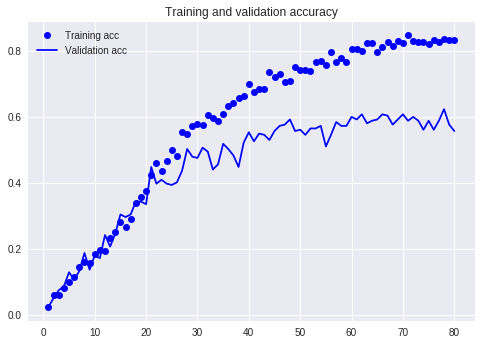

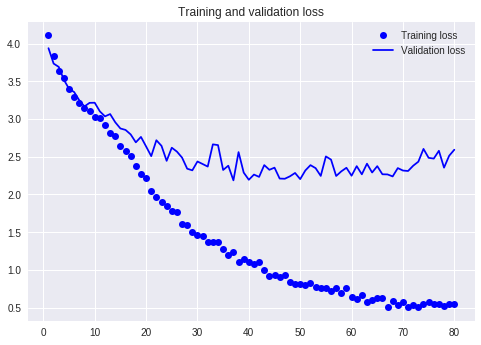

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()